In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

In [4]:
import stan_utility
import pystan
import matplotlib as mpl

import scipy.stats as stats
from scipy.stats import kde

In [5]:
light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
light_grey="#DDDDDD"

plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

## Task 1
## Gamma family distributions
Provide histograms of Gamma and invGamma distributions. See how tail behavior of those distributions behave. Using algebra_solver (see notebook from lecture on poisson distribution modelling) find parameters for Gamma and invGamma for which 98% probability is for values between 5 and 10. Sample for those distributions and compare histograms.

In [4]:
with open('stan_model/gamma.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real beta;
}

generated quantities {
    real gamma = gamma_rng(alpha, beta);
    real inv_gamma = inv_gamma_rng(alpha, beta);
}


In [5]:
gamma_model = stan_utility.compile_model('stan_model/gamma.stan')

Using cached StanModel


In [6]:
sim_md = gamma_model.sampling(data={'alpha': 7, 'beta': 2},
                              seed=1052020,
                              algorithm="Fixed_param",
                              iter=1000, 
                              warmup=0,
                              chains=1)

In [7]:
params=sim_md.extract()
gamma=params['gamma']
inv_gamma=params['inv_gamma']

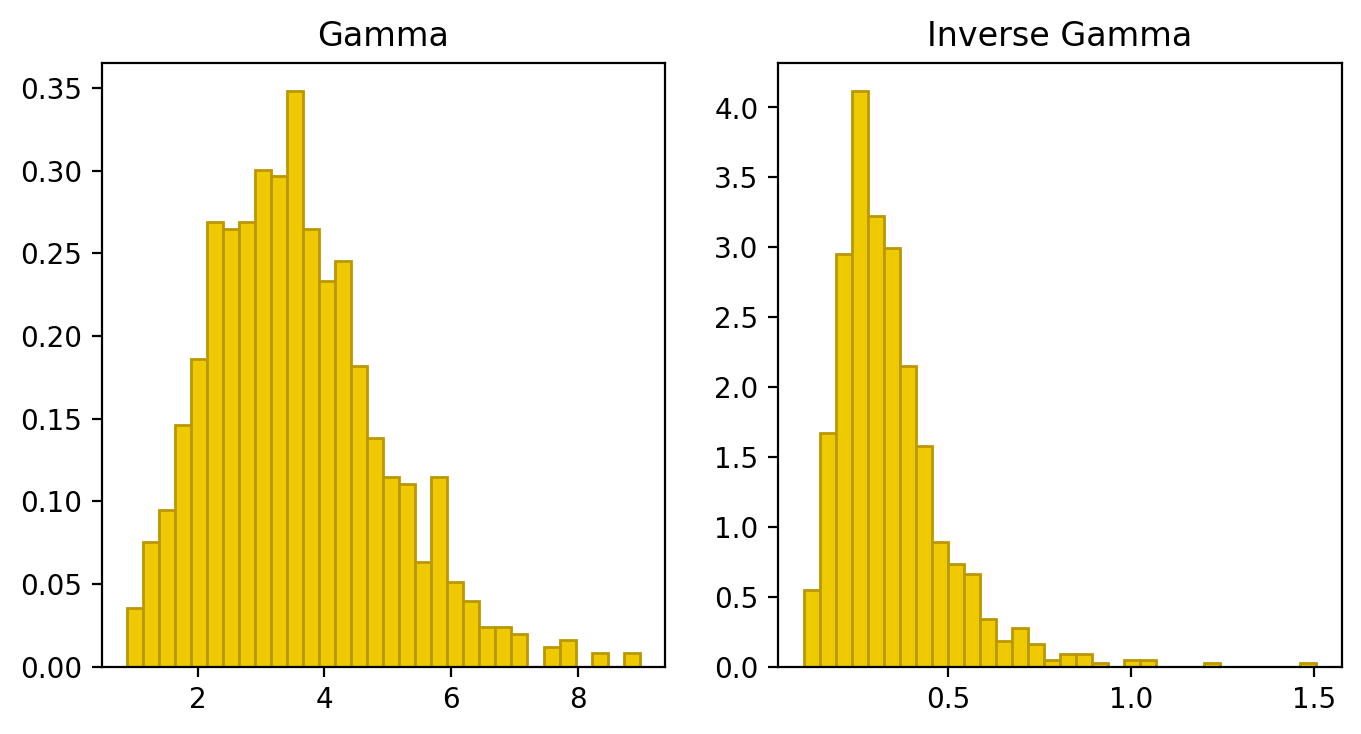

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,10,10)

ax2=axes[1]
ax2.hist(inv_gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,10)

ax1.set_title('Gamma')
ax2.set_title('Inverse Gamma')
plt.show()


In [9]:
with open('stan_model/gamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector gamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] gammas;
        gammas[1] = gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
        gammas[2] = 0.99 - gamma_cdf(theta[2], exp(y[1]), exp(y[2]));
        
        return gammas;
    }
}

data {
    real lower_bound;
    real upper_bound;
    real alpha_guess;
    real beta_guess;
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lower_bound, upper_bound]';
    
    vector[2] y_guess = [log(alpha_guess), log(beta_guess)]';
    y = algebra_solver(gamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}


In [10]:
gamma_tuning=stan_utility.compile_model('stan_model/gamma_tune.stan')

Using cached StanModel


In [11]:
data = dict(lower_bound =5 , upper_bound=10, alpha_guess=7, beta_guess=2)  
tuned = gamma_tuning.sampling(data=data,
                                seed=28052020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [12]:
alpha = np.round(tuned.extract()['alpha'][0])
beta = np.round(tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 46.0	beta: 6.0


In [13]:
sim_gamma = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [14]:
params=sim_gamma.extract()
par_gamma=params['gamma']

In [15]:
with open('stan_model/inv_gamma_tune.stan', 'r') as file:
    print(file.read())

functions {
    vector gamma (vector y, vector theta, real[] x_r, int[] x_i) {
        vector[2] gammas;
        gammas[1] = inv_gamma_cdf(theta[1], exp(y[1]), exp(y[2])) - 0.01;
        gammas[2] = 0.99 - inv_gamma_cdf(theta[2], exp(y[1]), exp(y[2]));

        return gammas;
    }
}

data {
    real lower_bound;
    real upper_bound;
    real alpha_guess;
    real beta_guess;
}

transformed data {
    vector[2] y;
    real x_r[0];
    int x_i[0];
    vector[2] theta = [lower_bound, upper_bound]';

    vector[2] y_guess = [log(alpha_guess), log(beta_guess)]';
    y = algebra_solver(gamma, y_guess, theta, x_r, x_i);
}

generated quantities {
    real alpha = exp(y[1]);
    real beta = exp(y[2]);
}


In [16]:
inv_gamma_tuning=stan_utility.compile_model('stan_model/inv_gamma_tune.stan')

Using cached StanModel


In [17]:
data = dict(lower_bound =5 , upper_bound=10, alpha_guess=2, beta_guess=5)
inv_tuned = inv_gamma_tuning.sampling(data=data,
                                seed=28052020,
                                algorithm="Fixed_param",
                                iter=1000, 
                                warmup=0,
                                chains=1)

In [18]:
alpha = np.round(inv_tuned.extract()['alpha'][0])
beta = np.round(inv_tuned.extract()['beta'][0])
print(f'alpha: {alpha}\tbeta: {beta}')

alpha: 46.0	beta: 314.0


In [19]:
sim_gamma_inv = gamma_model.sampling(data={'alpha': alpha, 'beta': beta},
                          algorithm="Fixed_param",
                          iter=1000,
                          warmup=0,
                          chains=1,
                          seed=25052020)

In [20]:
inv_params=sim_gamma_inv.extract()
par_inv_gamma=inv_params['inv_gamma']

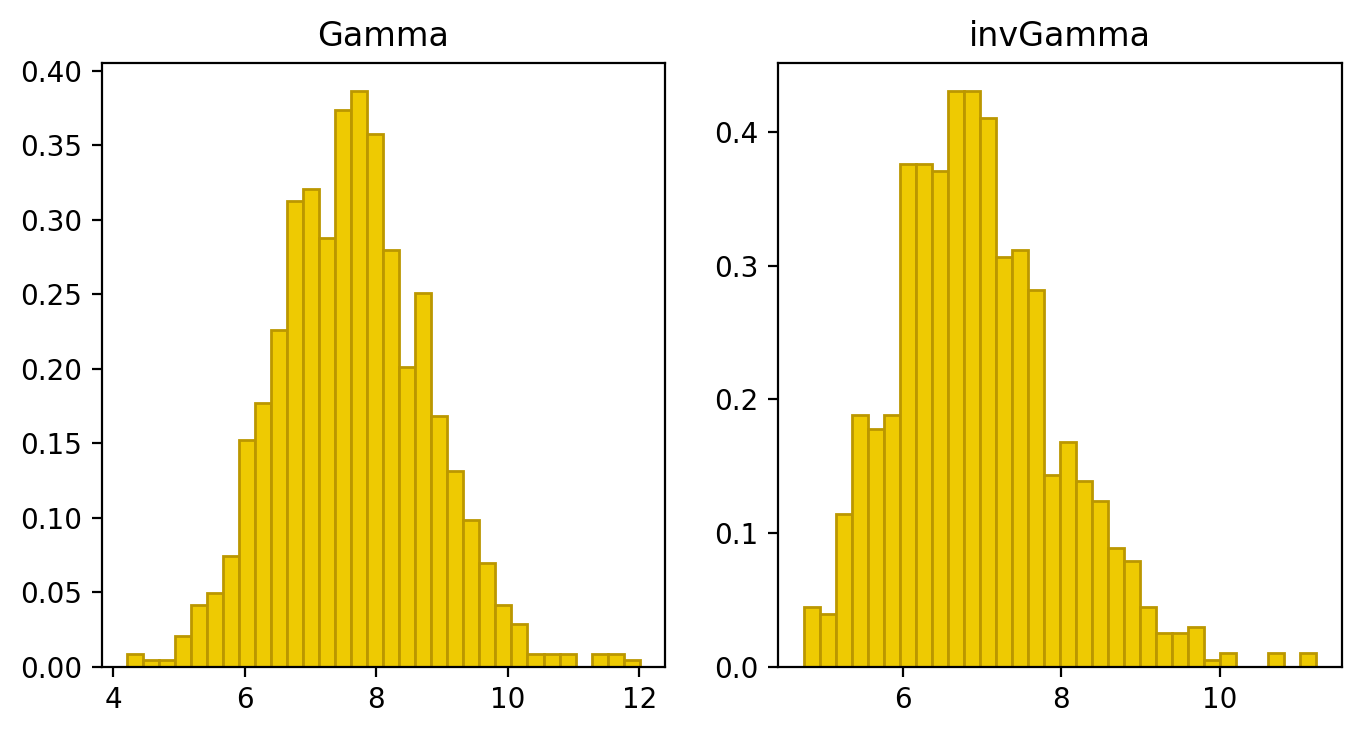

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax1=axes[0]
ax1.hist(par_gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)
x=np.linspace(0,10,500)

ax2=axes[1]
ax2.hist(par_inv_gamma,bins=32,color=dark,edgecolor=dark_highlight,density=True)
x2=np.linspace(0,10,500)

ax1.set_title('Gamma')
ax2.set_title('invGamma')
plt.show()

### Conclusion
### Gamma Distribution
Increase of $\theta$ causes the distribution to change concentration area from the very beggining move to the right. Whereas the exponents flattens out, as the exponent is decreasing.

## Task 2
## Negative binomial distribution
Negative binomial distribution can be used in order to relax the constraints of equal mean and variance of Poissson distribution. Using both concentration and dispersion parametrization sample from negative binomial with fixed mean and see how it behaves in comparison to the Poisson with the same mean.

In [6]:
with open('stan_model/negative.stan', 'r') as file:
    print(file.read())

data {
    real alpha;
    real mu;
    real phi;
}

generated quantities {
    real neg_bin_con = neg_binomial_rng(alpha, alpha/mu);
    real neg_bin_dis = neg_binomial_2_rng(mu, phi);

    real poisson_con = poisson_rng(mu);
}


In [7]:
negative_binomial_model = stan_utility.compile_model('stan_model/negative.stan')

Using cached StanModel


In [8]:
data = dict(alpha=3, mu=15, phi=3) 
negative_binomial_sampled = negative_binomial_model.sampling(data=data,
                                                    seed=25052020,
                                                    algorithm="Fixed_param",
                                                    iter=1000, 
                                                    warmup=0,
                                                    chains=1)

In [25]:
params=negative_binomial_sampled.extract()
neg_bin_con=params['neg_bin_con']
neg_bin_dis=params['neg_bin_dis']
poisson_con=params['poisson_con']

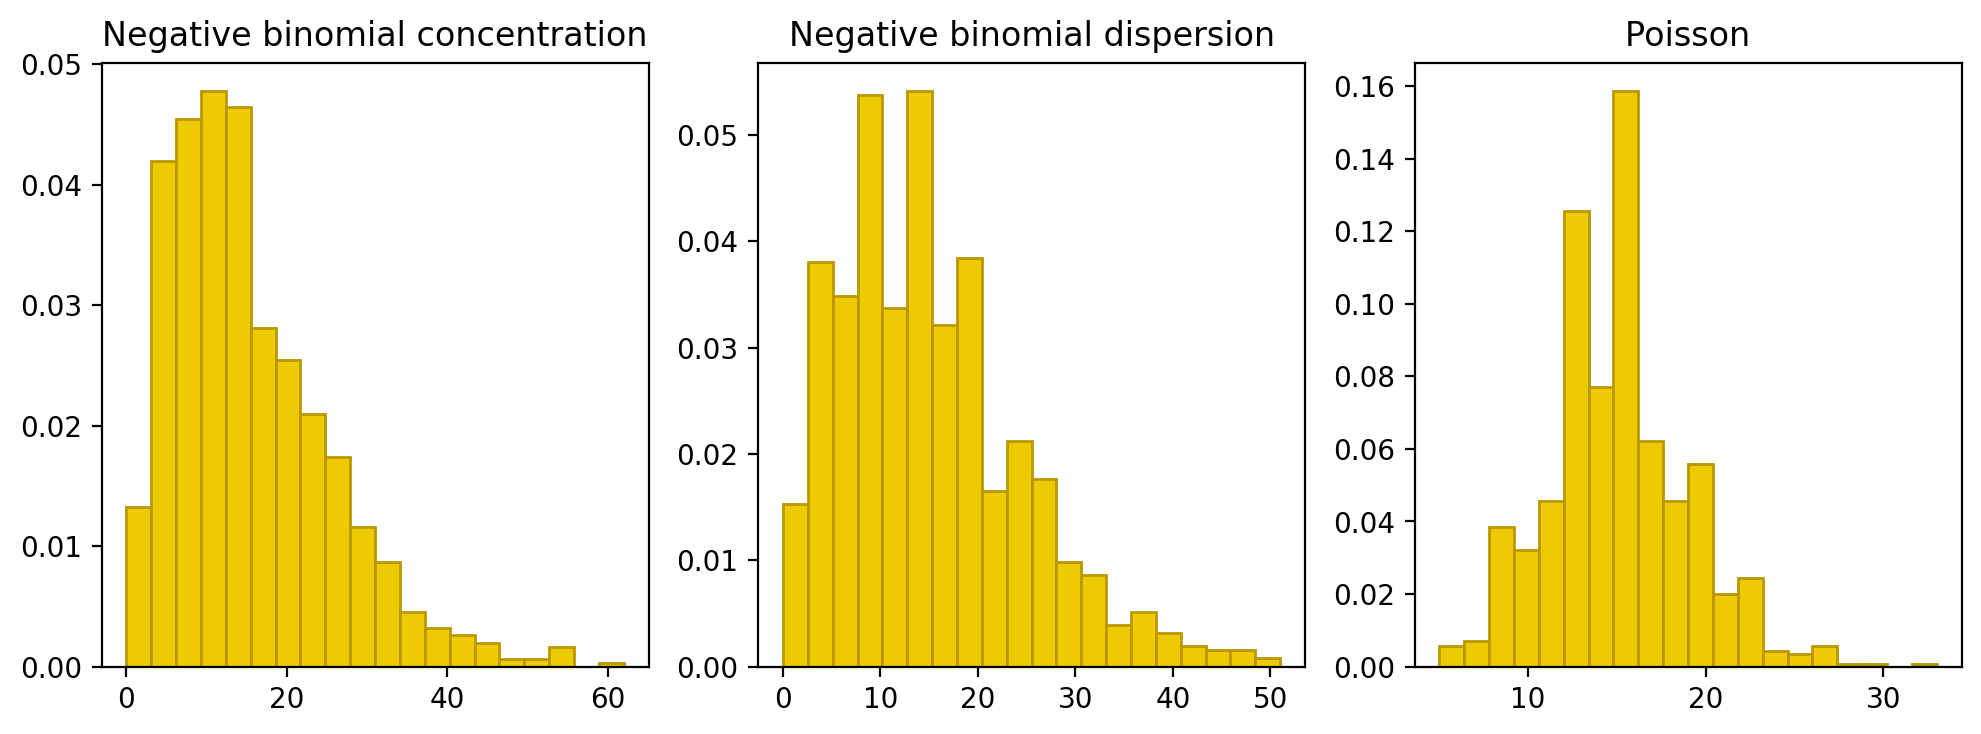

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

ax1=axes[0]
ax1.hist(neg_bin_con,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax1.set_title(r'Negative binomial concentration')

ax3=axes[1]
ax3.hist(neg_bin_dis,bins=20, color=dark, edgecolor=dark_highlight, density=True)
ax3.set_title(r'Negative binomial dispersion')

ax2=axes[2]
ax2.hist(poisson_con,bins=20,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('Poisson')

plt.show()

## Conclusion

Poisson distribution have a uncertainty defined in terms of the amount of expected successes. It has an expected value of $\lambda$ and standard deviation of $\sqrt{\lambda}$.
The uncertainty increases, because of a larger amount of trials performed during this timeframe.
The amount of successes increases relatively slightly in comparision to the amount of trials that have been performed during wider timeframe.

The negative binomial distribution is defined by the probability of the total amount of failures, which will occur until a set value of successes will be reached. For instance, for the probability of success = 0.5, the expected amount of failures is equal to the amount of successes. If the probability of success increase - the expected amount of failues will decrease.

In comparision to Poisson distribution, for which the number of trials is infinite, the (1-p) reaches the value of 1, so this is why it's standard deviation is equal to $\sqrt{\lambda}$.

## Task 3
## Student-t family distribution
Student-t distributions can be considered generalizations of Gaussian distributions with varying scale. Use both degrees of freedom and dispersion parametrizations to see how changing parameters moves from normal distribution. Take a special case of degrees of freedom equal to 1, as this is Cauchy distribution. See how mean and variance behave while you increase number of samples.

In [9]:
with open('stan_model/student_t.stan', 'r') as file:
    print(file.read())

data {
    real nu;    //degrees of freedom
    real mu;    //location
    real sigma; //scale sigma
}

generated quantities {
    real y = student_t_rng(nu, mu, sigma);
}


In [10]:
student_t_model = stan_utility.compile_model('stan_model/student_t.stan')

Using cached StanModel


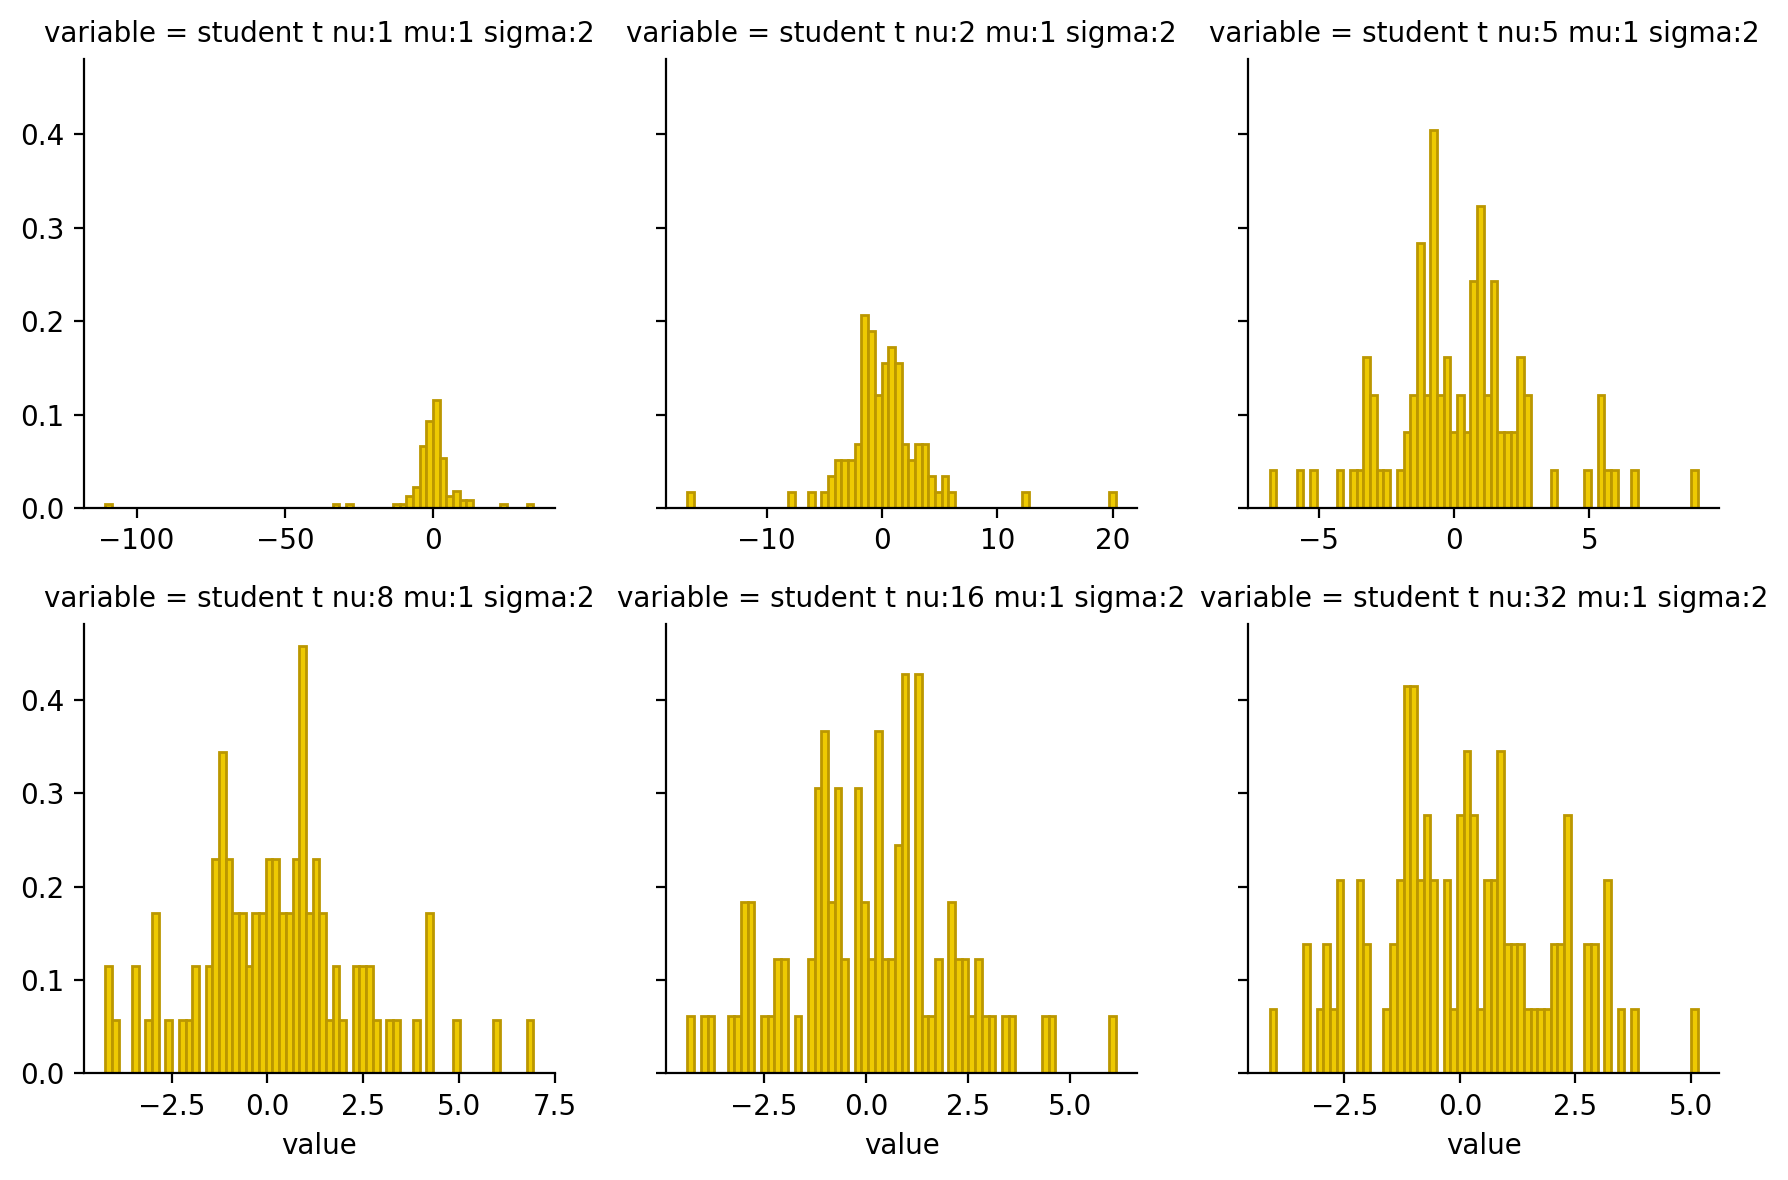

In [14]:
freedom_degrees = [1, 2, 5, 8, 16, 32]
student_dict: dict = {}

for free_deg in freedom_degrees:
        sim_student=student_t_model.sampling(data={'nu':free_deg, 'mu':0, 'sigma':2},
                      algorithm="Fixed_param",
                      iter=100,
                      warmup=0,
                      chains=1,
                      seed=42342)
        params_student=sim_student.extract()
        student=params_student['y']
        student_dict['student t nu:{} mu:1 sigma:2'.format(free_deg)] = student

student_df = pd.DataFrame.from_dict(student_dict)
melted_student = student_df.melt()

graph = sns.FacetGrid(melted_student, col="variable", sharey=True, sharex=False, col_wrap=3)
graph.map(plt.hist, "value", cumulative=False, bins=64, color=dark,edgecolor=dark_highlight,density=True)

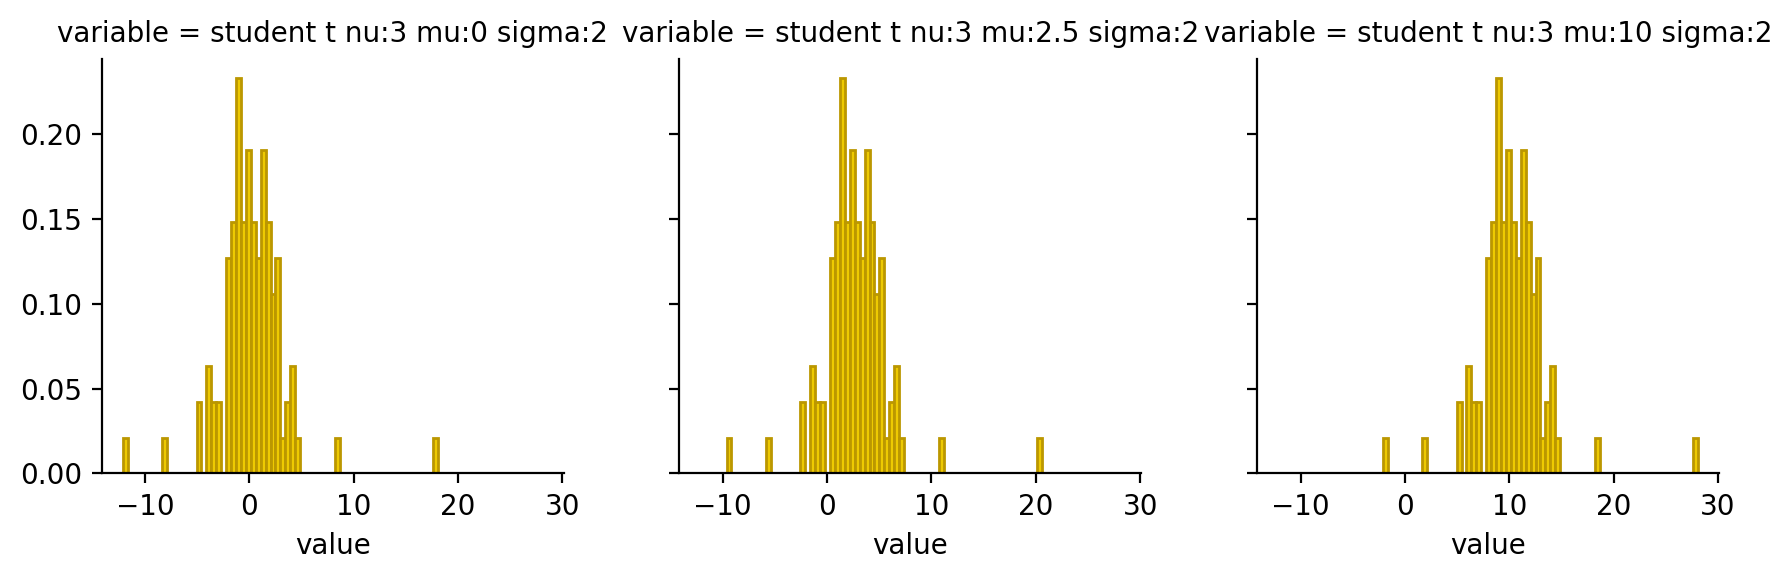

In [17]:
variance = [0, 2.5, 10]
student_dict: dict = {}

for var in variance:
        sim_student=student_t_model.sampling(data={'nu':3, 'mu':var, 'sigma':2},
                      algorithm="Fixed_param",
                      iter=100,
                      warmup=0,
                      chains=1,
                      seed=42342)
        params_student=sim_student.extract()
        student=params_student['y']
        student_dict['student t nu:3 mu:{} sigma:2'.format(var)] = student

student_df = pd.DataFrame.from_dict(student_dict)
melted_student = student_df.melt()

Graph = sns.FacetGrid(melted_student, col="variable", sharey=True, sharex=True, col_wrap=3)
Graph = Graph.map(plt.hist, "value", cumulative=False, bins=64, color=dark,edgecolor=dark_highlight,density=True)

In [18]:
sim_cauchy_100=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=100,
                      warmup=0,
                      chains=1,
                      seed=42342)
sim_cauchy_250=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=250,
                      warmup=0,
                      chains=1,
                      seed=42342)
sim_cauchy_500=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=500,
                      warmup=0,
                      chains=1,
                      seed=42342)
sim_cauchy_1000=student_t_model.sampling(data={'nu':1, 'mu':0, 'sigma':1},
                      algorithm="Fixed_param",
                      iter=1000,
                      warmup=0,
                      chains=1,
                      seed=42342)

params_cauchy_100=sim_cauchy_100.extract()
cauchy_100=params_cauchy_100['y']

params_cauchy_250=sim_cauchy_250.extract()
cauchy_250=params_cauchy_250['y']

params_cauchy_500=sim_cauchy_500.extract()
cauchy_500=params_cauchy_500['y']

params_cauchy_1000=sim_cauchy_1000.extract()
cauchy_1000=params_cauchy_1000['y']

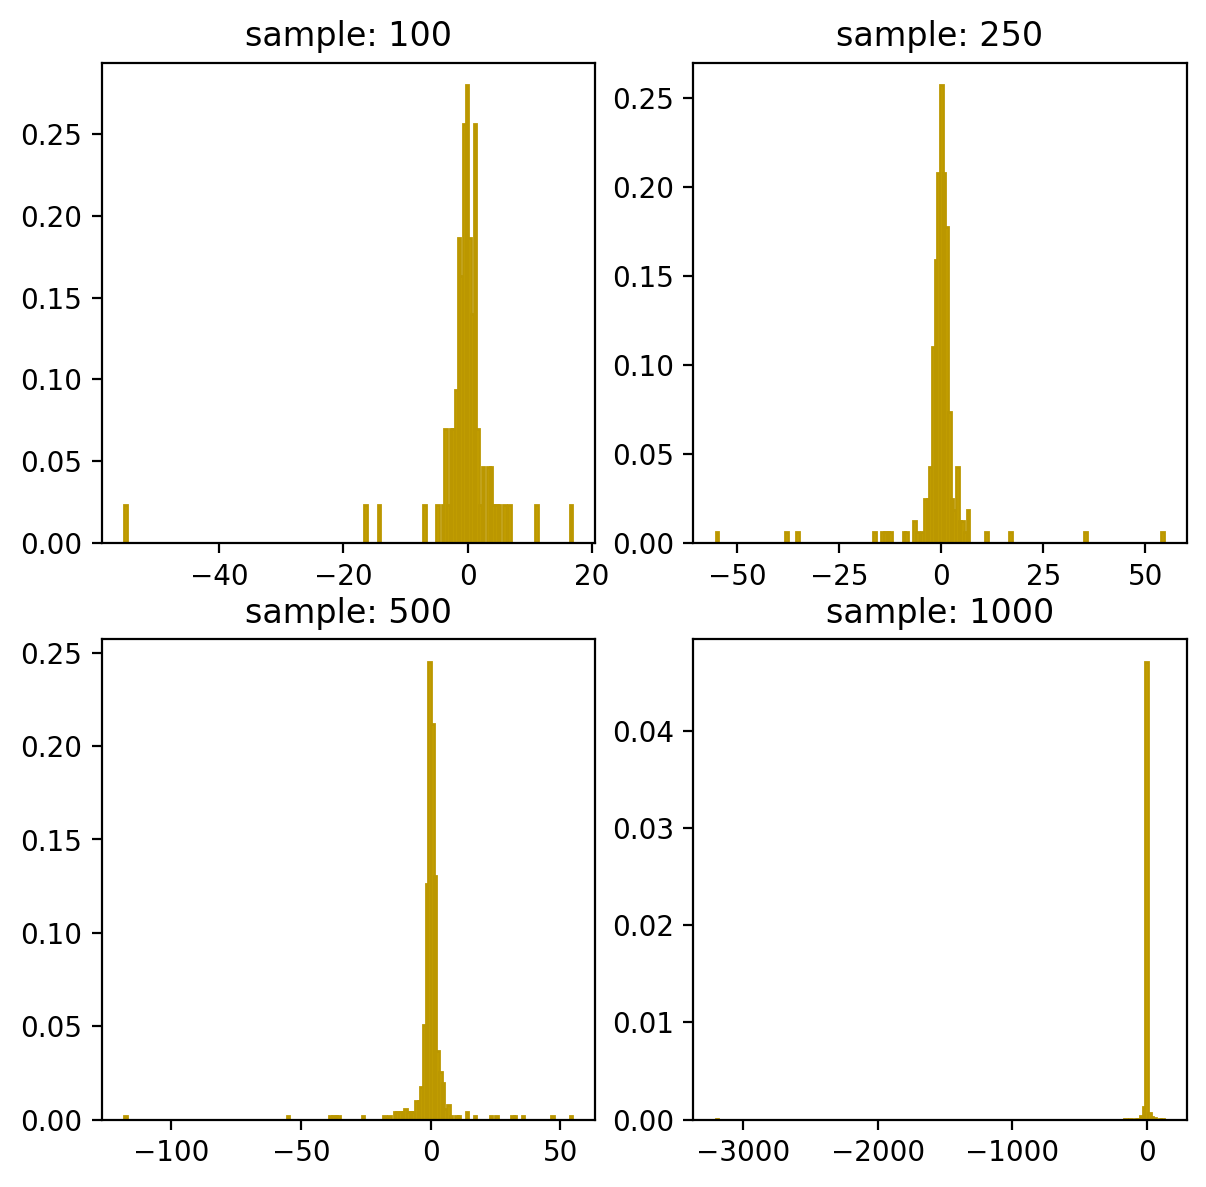

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))

ax1=axes[0][0]
ax1.hist(cauchy_100,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('sample: 100')

ax2=axes[0][1]
ax2.hist(cauchy_250,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('sample: 250')

ax3=axes[1][0]
ax3.hist(cauchy_500,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax3.set_title('sample: 500')

ax4=axes[1][1]
ax4.hist(cauchy_1000,bins=168,color=dark,edgecolor=dark_highlight,density=True)
ax4.set_title('sample: 1000')

plt.show()

In [33]:
print("Median")
# print(f'student_t 100 samples: {np.median(student_100)}\tstudent_t 1000 samples: {np.median(student_1000)}')
print(f'cauchy 100 samples: {np.median(cauchy_100)}\tcauchy 1000 samples: {np.median(cauchy_1000)}')
print("Variance")
# print(f'student_t 100 samples: {np.var(student_100)}\tstudent_t 1000 samples: {np.var(student_1000)}')
print(f'cauchy 100 samples: {np.var(cauchy_100)}\tcauchy 1000 samples: {np.var(cauchy_1000)}')

Median
cauchy 100 samples: -0.0203387902226468	cauchy 1000 samples: 0.08468845136467383
Variance
cauchy 100 samples: 43.3945642165011	cauchy 1000 samples: 10384.029979590508


## Conclusion

# Multivariate normal distribution
Consider density plots and 2d histograms for visualisation of behavior of 2 dimensional Multivariate normal. Use the correlation matrix decompositon of covariance matrix to see how individual variances and correlations infulence the distribution. For 3 and 4 dimensional normal distributions observe the marginals of variables with histograms.

In [34]:
multivariate_normal_model=stan_utility.compile_model('stan_model/multi_normal.stan')

Using cached StanModel


In [35]:
data = dict(mu=[1, 0], sigma=[[1, 0.5],[0.5, 1]], eta=2)
multivariate_normal_sampling = multivariate_normal_model.sampling(data=data,
                                                                  seed=2852020,
                                                                  algorithm="Fixed_param",
                                                                  iter=1000, 
                                                                  warmup=0,
                                                                  chains=1)

In [36]:
params=multivariate_normal_sampling.extract()
y_sim=params['result'].T
corrMatrix=params['correl_matrix']

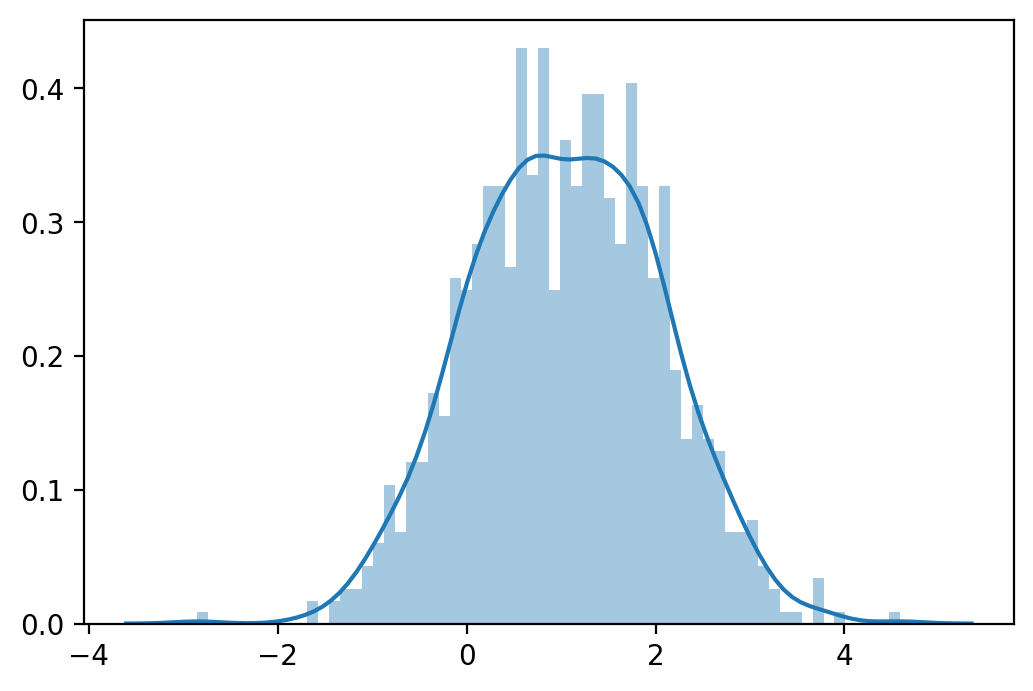

In [37]:
sns.distplot(y_sim[0].flatten(), hist=True, kde=True, bins=64)

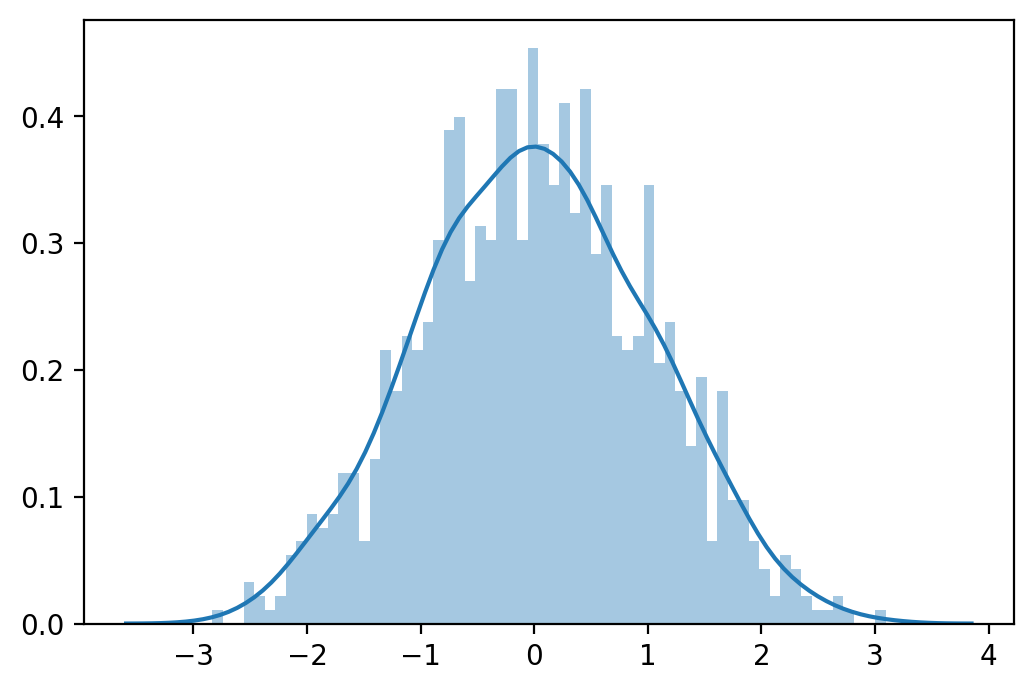

In [38]:
sns.distplot(y_sim[1].flatten(), hist=True, kde=True, bins=64)

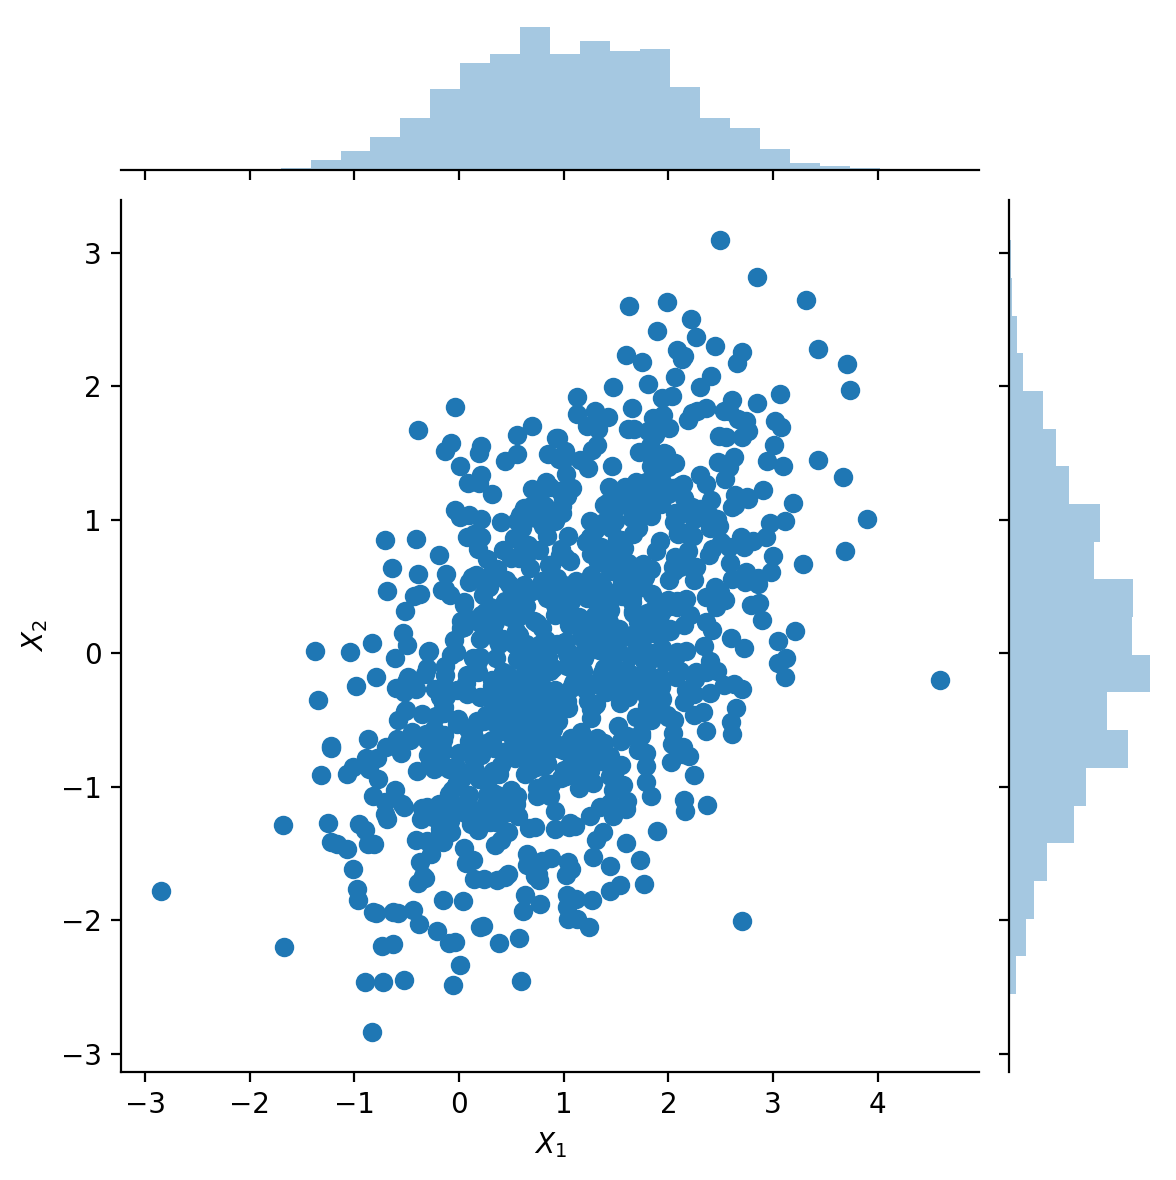

In [39]:
x1=pd.Series(y_sim[0], name="$X_1$")
x2=pd.Series(y_sim[1], name="$X_2$")

g = sns.jointplot(x1, x2)

In [40]:
multivariate_normal_N_model = stan_utility.compile_model('stan_model/multi_normal_N.stan')

Using cached StanModel


In [41]:
mu = [0, 0, 0]
sig = [(1, .5, .3), (.5, 1, .5), (.3, .5, 1)]
multivariate_normal_sampled=multivariate_normal_N_model.sampling(data={'N': len(mu), 'mu': mu, 'sig': sig}, iter=1000, seed=43541)

In [42]:
param = multivariate_normal_sampled.extract()
result = param['y']
result = result.T

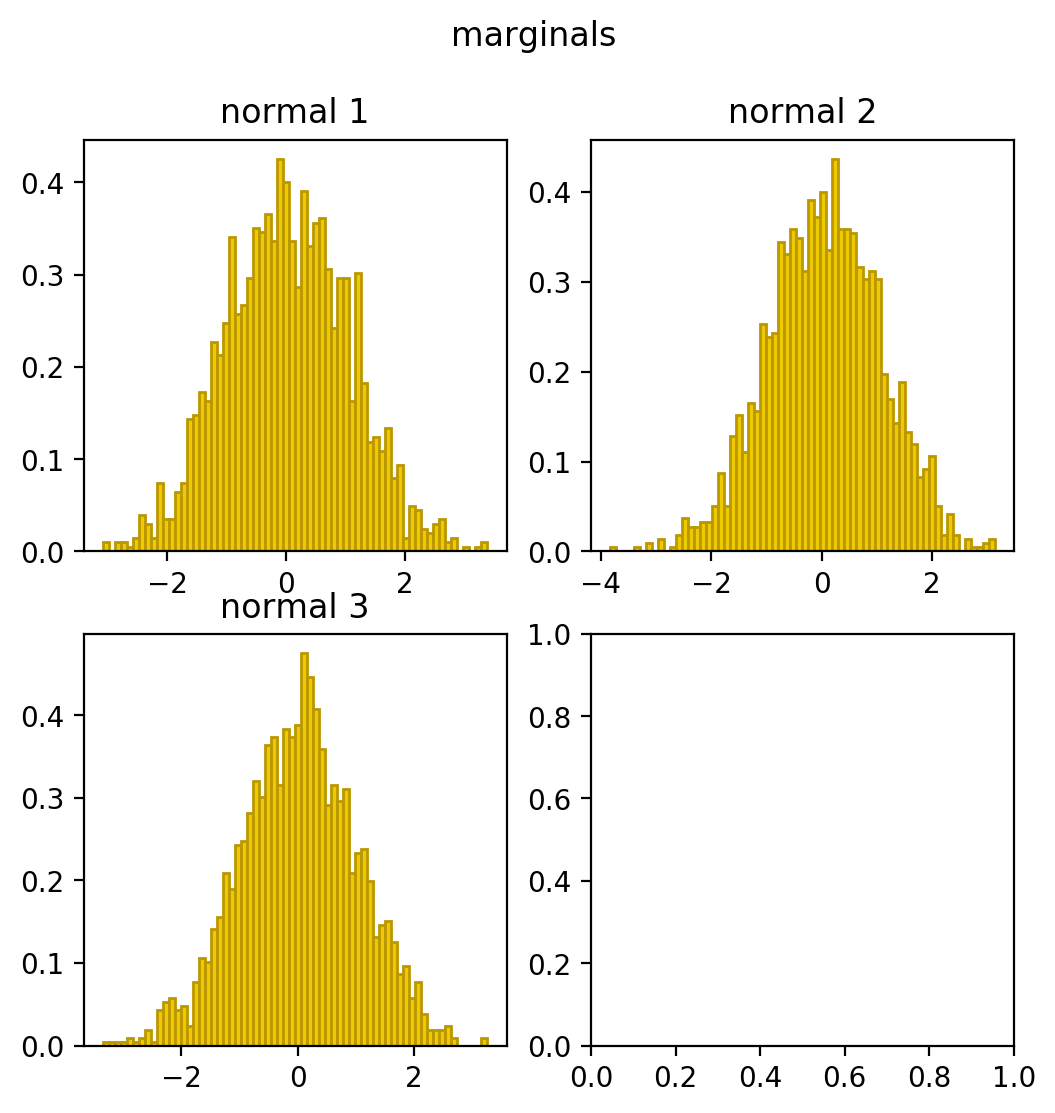

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))

fig.suptitle('marginals')

ax1=axes[0][0]
ax1.hist(result[0],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('normal 1')

ax2=axes[0][1]
ax2.hist(result[1],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal 2')

ax2=axes[1][0]
ax2.hist(result[2],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal 3')

plt.show()

In [44]:
mu = [0,0,0,0]
sig = [(1, .7, .7, .7), (.7, 1, .7,.7), (.7, .7, 1,.7), (.7,.7,.7,1)]

multivariate_normal_4_sampled=multivariate_normal_N_model.sampling(data={'N': len(mu),
                                                                         'mu': mu,
                                                                         'sig': sig},
                                                                         iter=1000,
                                                                         seed=43541)

In [45]:
param = multivariate_normal_4_sampled.extract()
result = param['y']
result = result.T

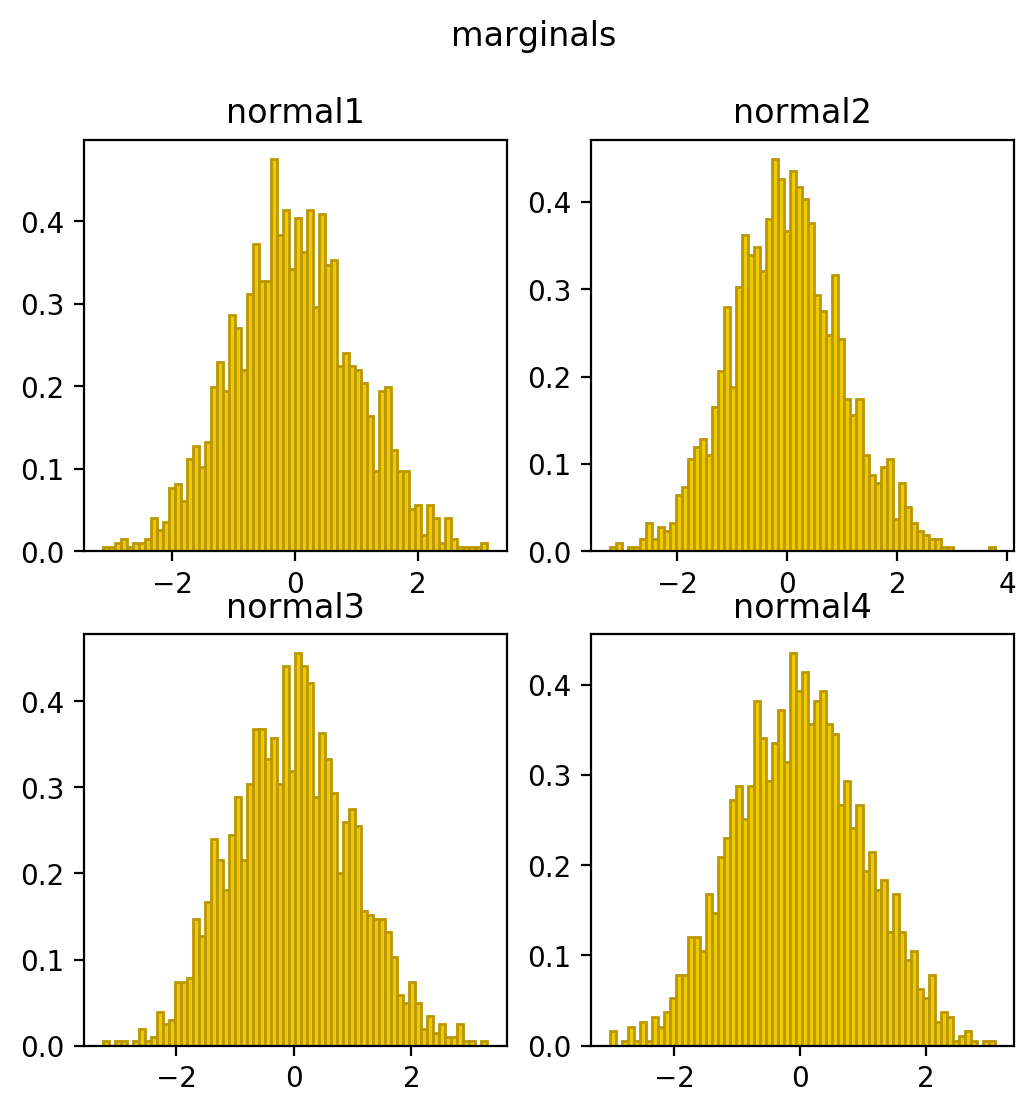

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(6,6))

fig.suptitle('marginals')

ax1=axes[0][0]
ax1.hist(result[0],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax1.set_title('normal1')

ax2=axes[0][1]
ax2.hist(result[1],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal2')

ax2=axes[1][0]
ax2.hist(result[2],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal3')

ax2=axes[1][1]
ax2.hist(result[3],bins=64,color=dark,edgecolor=dark_highlight,density=True)
ax2.set_title('normal4')

plt.show()

## Conclusion